In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import igraph

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/permutahedron/DG_PHD_6.txt
/kaggle/input/permutahedron/IM_PHD_6.csv
/kaggle/input/lrx-oeis-a-186783-brainstorm-math-conjecture/sample_submission.csv
/kaggle/input/lrx-oeis-a-186783-brainstorm-math-conjecture/test.csv


# Loading data

In [3]:
df = pd.read_csv('/kaggle/input/permutahedron/IM_PHD_6.csv', sep=';')
df.head()

,row,col,val,pair
0,0,1,1,"(0, 1)"
1,0,2,1,"(0, 2)"
2,0,3,1,"(0, 3)"
3,0,4,1,"(0, 4)"
4,0,5,1,"(0, 5)"


# Init graph

In [4]:
g = igraph.Graph()
nodes = set(df['row'].values).union(df['col'].values)
# init graph from df
g.add_vertices(len(nodes))
g.add_edges(zip(df['row'].values, df['col'].values))

# Making Layout
## What is Going On and Why Not Force Atlas

There are many ways to assign coordinates to vertices (what is called layout). The most popular algorithm is Force Atlas. Its advantages are speed (due to Barnes-Hut optimization) and readability (clusters in visualization are also graph communities). However, force-directed layouts work best with scale-free networks and are used mostly for social data. Such graphs have dense clusters, something that can be called a center, and a sparse periphery. They are also very irregular and have no simple structure, so visualization does not have to capture special geometrical features of the data.

Cayley graphs are different. They have strong symmetry and also have constant density that does not change with distance, so the main advantage of Force Atlas -- clustering -- becomes a disadvantage. Iterative approximate algorithms do not capture symmetry and are too dependent on initialization.

## Why MDS
In contrast, MDS tries to preserve all the pairwise distances between vertices, so if some distances are equal in the graph, MDS will try to preserve them while assigning coordinates. The relative positions of symmetrical vertices will also maintain their symmetry in the result. Empirical results prove this. While Force Atlas converges to different states and can stick together vertices that have long distances between them, MDS gives good insight into the geometry of Cayley graphs.

## Further Work
It's possible that the main reason why Force Atlas does not give good results is the optimizations and heuristics that work well for scale-free networks. But there are many force-directed and energy-based algorithms that could possibly do better work. The most promising candidates are those that optimize the overall energy of the system, but it is also expected that the best result will not differ significantly from MDS.

In [5]:
%%time
layout = g.layout_mds(dim=3)

CPU times: user 430 ms, sys: 14.3 ms, total: 444 ms
Wall time: 450 ms


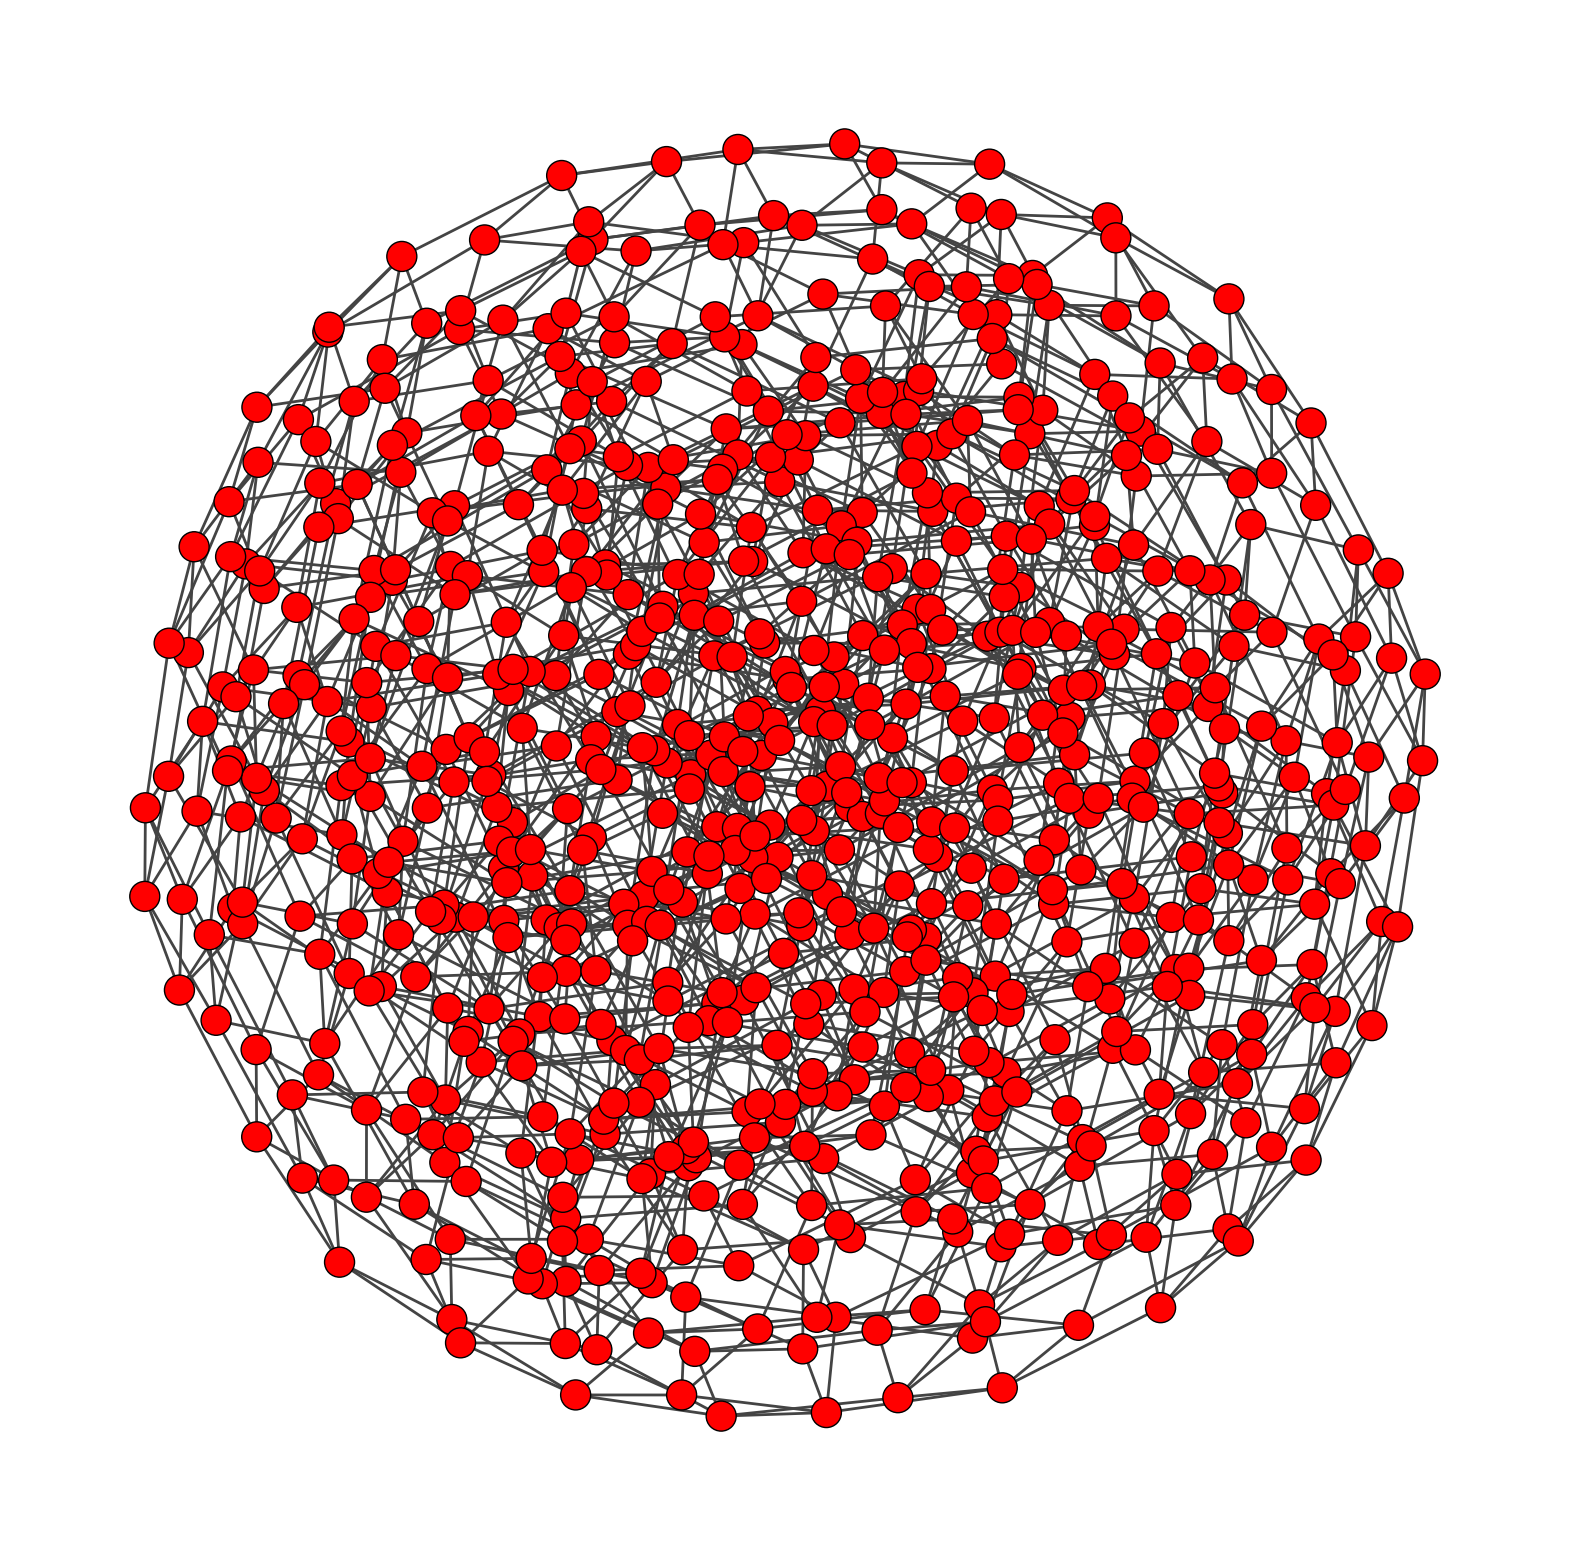

In [6]:
plt.figure(figsize=(20, 20))
ax = plt.gca()
igraph.plot(g, target=ax)

# Draw with matplotlib
Because default igraph drawing is not so good

In [7]:
def draw_graph(edges, coords):
    plt.figure(figsize=(20, 20))
    for source, target in edges:
        plt.plot([coords[source][0], coords[target][0]], [coords[source][1], coords[target][1]],
                  'k-', linewidth=0.5)
    plt.xticks([])
    plt.yticks([])

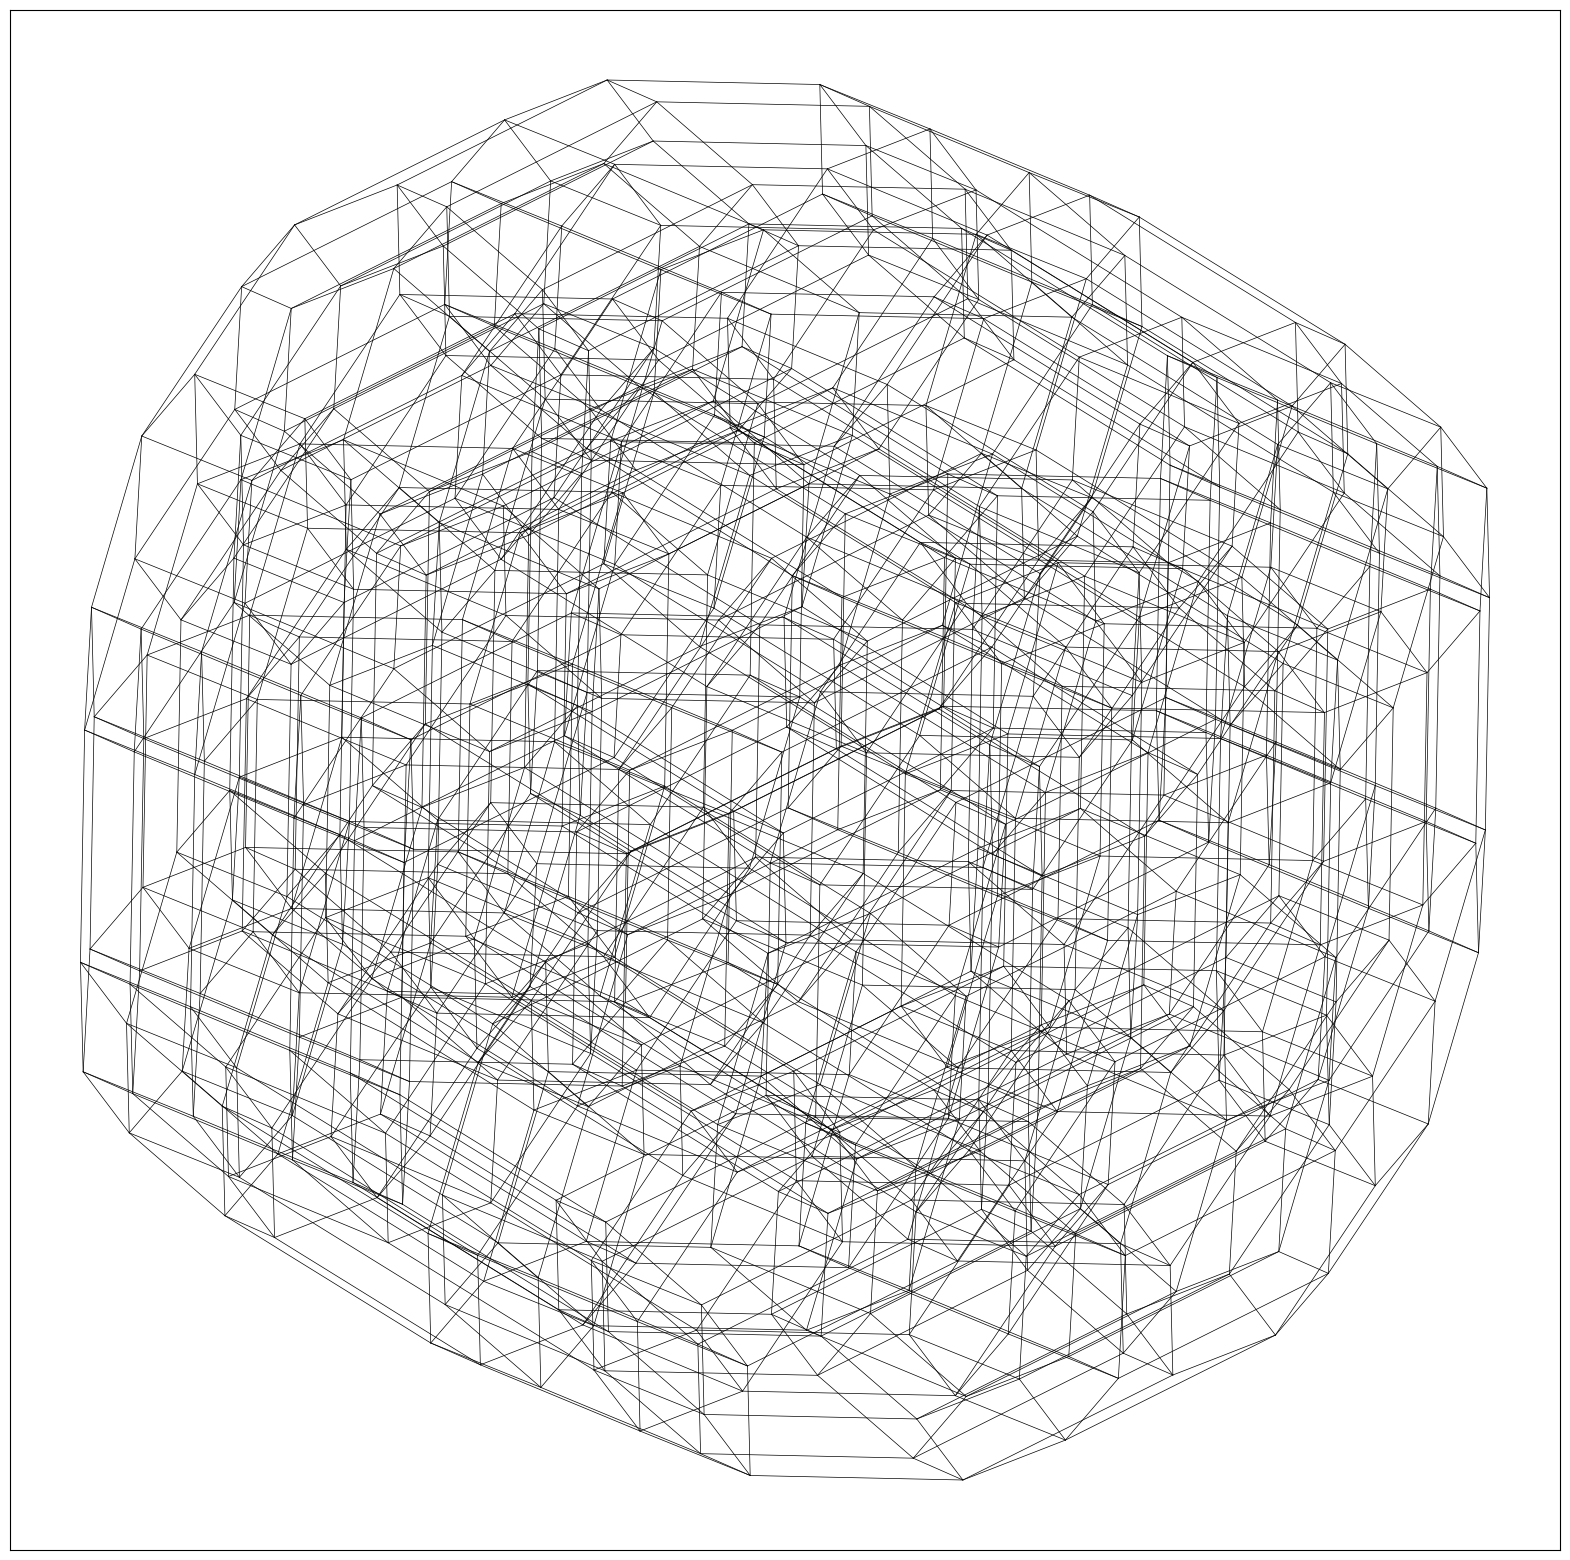

In [8]:
draw_graph(g.get_edgelist(), {i: (x, y, z) for i, (x, y, z) in enumerate(layout.coords)})

# Interactive visualization with plotly

In [9]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

# Initialize Plotly in offline mode
init_notebook_mode(connected=True)

In [10]:
coords = np.array(layout.coords)

In [11]:
fig = go.Figure()

# Add individual line segments for each edge
for source, target in g.get_edgelist():
    # Get coordinates for source and target nodes
    x = [coords[source][0], coords[target][0]]
    y = [coords[source][1], coords[target][1]]
    z = [coords[source][2], coords[target][2]]
    
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color='blue', width=3),
    ))

# Optional: Add node markers
# node_x = coords[:, 0]
# node_y = coords[:, 1]
# node_z = coords[:, 2]

# fig.add_trace(go.Scatter3d(
#     x=node_x,
#     y=node_y,
#     z=node_z,
#     mode='markers',
#     marker=dict(
#         size=6,
#         color='red',
#         line=dict(width=2, color='black')
#     ),
#     name='Nodes'
# ))

# Configure layout
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show(renderer='iframe')
